### David Laziuk
### CS 584 Final Project
#### Transformers in Financial NLP: Market Movements from 8-K reports
####  
Note: Running this notebook is intensive.  
Single-threaded operations take ~50 hours on an M2 Pro.  
Fine-tuning takes ~16 hours on a NVIDIA RTX A6000.  

In [19]:
# Imports
import os
import re
import sys
import nltk
import random
import shutil
import chardet
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from statistics import mean
from itertools import cycle
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sec_edgar_downloader import Downloader
from sklearn.metrics import mean_absolute_error, mean_squared_error
nltk.download('punkt')
nltk.download('words')
from nltk.corpus import words
# Linear Regression 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# SVM Imports
from sklearn.svm import SVR
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# BERT Imports
import torch.nn as nn
from torch.optim import AdamW
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/davidlaziuk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/davidlaziuk/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Data Collection:
Download ALL historical 8-K filings from all companies CURRENTLY in the S&P500.  

In [ ]:
# Download all 8-K Filings for current S&P500 companies

# WARNING: This download is ~140 GB ! It will take a MINIMUM of 4hrs due to rate limits

# Load spreadsheet of current SP500 companies from: https://topforeignstocks.com/indices/components-of-the-sp-500-index/
# Note:
# BRKB changed to BRK-B
# BFB changed to BF-B
# ATVI (Activision) deleted to to aquisition on OCT 12, 2023
# GBP, USD deleted due to being currency
sp500 = pd.read_excel('SP500.xlsx')
# Create a dictionary with ticker as key and company name as value
tickers_dict = sp500.set_index('Ticker')['Company Name'].to_dict()

# Use sec_edgar_downloader to download all filings
downloader = Downloader("dlaziuk", "dlaziuk@stevens.edu")
for ticker, name in tickers_dict.items():
    # Create a directory path for the filings
    dir_path = f"sec-edgar-filings/{ticker.upper()}"
    # Check if the directory exists, if not, attempt to download the 8-K filings
    if not os.path.exists(dir_path):
        try:
            # Attempt to download the 8-K filings for the given ticker
            downloader.get("8-K", ticker, include_amends=False)
            print(f"{ticker},", end=' ')
        except Exception as e:
            print(f"Invalid ticker: {ticker}: Error {e}")
    else:
        print(f"{ticker},", end=' ')

# Text Cleaning
The full 8-K filings download as a .txt that seems to be a renamed html page.  
This requires heavy cleaning.  
Additionally, I will include some text enhancement to make the reports as consistent and machine-interpretable as possible.  
This advanced cleaning is very demanding on ~145k reports, so it will take several hours.  

In [ ]:
def print_progress_bar(iteration, total, bar_length=50):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(bar_length * iteration // total)
    bar = '█' * filled_length + '-' * (bar_length - filled_length)
    sys.stdout.write(f'\rProgress: |{bar}| {percent}% Complete {iteration}/{total}')
    sys.stdout.flush()

count = 0
del_count = 0
word_list = set(words.words())
total_dirs = sum([len(dirs) for r, dirs, f in os.walk('sec-edgar-filings')])
print('Walk Order: ', end='')
# Iterate through all files in the report directory
for root, dirs, files in os.walk('sec-edgar-filings'):
    # Print walk order:
    if root == 'sec-edgar-filings':
        for d in dirs:
            print(f'{d}, ', end='')
        print()
    # Start processing
    for file in files:
        if file.endswith('.txt'):
            count+=1
            if count % 100 == 0:
                print_progress_bar(count, total_dirs)
            # Load text
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
            except UnicodeDecodeError:
                print(f"Could not detect encoding for {file_path}. Skipping file.")
                continue
            except Exception as e:
                print(f"An unexpected error occurred while processing {file_path}: {e}")
                continue

            # Search for DATETIME in the first part of the text
            acceptance_datetime = None
            for line in text.splitlines()[:20]:
                if '<ACCEPTANCE-DATETIME>' in line:
                    acceptance_datetime = line.split('>')[1].strip()
                    break

            # If ACCEPTANCE-DATETIME not found, delete the folder containing the .txt   
            if not acceptance_datetime:
                folder_to_delete = os.path.dirname(file_path)
                shutil.rmtree(folder_to_delete)
                del_count += 1                
                
            # If DATETIME exists, proceed with processing    
            else:
                try:
                    # HTML CLEANING: 
                    # Strip HTML tags from the text
                    text = re.sub('<.*?>', '', text, flags=re.DOTALL)
                    # Remove numeric HTML entities ("&#8221;") / named character entities (&nbsp;)
                    text = re.sub(r'&(#\d+|[a-zA-Z]+);', ' ', text)
                    # Remove non-printable chars
                    text = re.sub(r'[^\x20-\x7E]', ' ', text)
                    # Seperate joined words like "OfficerExhibit" -> "Officer Exhibit"
                    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)  
                    # Convert all text to lowercase
                    text = text.lower()
                    # Chop top
                    text = ' '.join(text.split())
                    possible = [text.find("exact name"), text.find("employer identification")]
                    possible = [n for n in possible if n >= 0]
                    if possible:
                        item_index = min(possible)
                        text = text[item_index:]

                    # Find start
                    items=['entry into a material', 'entry into a definitive','termination of a material', 'bankruptcy or receivership', 'completion of acquisition',
                         'results of operation', 'creation of a direct', 'triggering events', 'costs associated',
                         'material impairments', 'notice of delisting', 'unregistered sales', 'material modification',
                         'changes in registrant', 'non-reliance', 'changes in control', 'departure of directors', 'amendments to articles',
                         'amendments to the registrant', 'submission of matters', 'regulation fd', 'other events', 'other information',
                           'other items', 'financial statements', 'election of director']

                    indexes = [text.find(s) for s in items]
                    found_indexes = [index for index in indexes if index != -1]
                    if found_indexes:
                        earliest_index = min(found_indexes)
                        text = text[earliest_index:]
                    else: 
                         #Find and remove everything before the first occurrence of "Item"
                        item_index = text.find("Item")
                        if item_index != -1:
                            text = text[item_index+4:]

                    # Remove everything after the first instance of "GRAPHIC {#}"
                    text = ' '.join(text.split())
                    text = re.sub(r'GRAPHIC \d+.*', '', text)
                    # Remove everything after ' EX-101.SCH '
                    text = re.sub(r'EX-101\.SCH.*', '', text, flags=re.DOTALL)
                    text = re.sub(r'-----END PRIVACY-ENHANCED MESSAGE-----', '', text)

                    #GENERAL CLEANING
                    # Remove all links
                    text = re.sub(r'https://[^\s]+', ' ', text)
                    text = re.sub(r'http://[^\s]+', ' ', text)
                    text = re.sub(r'\bwww\.[^ ]+', ' ', text)
                    text = re.sub(r'\b\S*\.com\b', ' ', text)
                    text = re.sub(r'\b\S*\.htm\b', ' ', text)
                    text = re.sub(r'\b\S*\.html\b', ' ', text)
                    text = re.sub(r'\b\S*\.org\b', ' ', text)
                    text = re.sub(r'\b\S*\.gov\b', ' ', text)
                    text = re.sub(r'\b\S*\.txt\b', ' ', text)
                    # Remove commas from compound numbers
                    text = re.sub(r'(?<=\d),(?=\d)', '', text)
                    # Replace all 'percent' with '%'
                    text = text.replace('percent', '%')
                    # Insert a space to the LEFT and RIGHT of every '$', ')', '(', '%'
                    text = re.sub(r'\$', ' $ ', text)
                    text = re.sub(r'\(', ' ( ', text)
                    text = re.sub(r'\)', ' ) ', text)
                    text = re.sub(r'\%', ' % ', text)
                    # Insert a space between every number that is directly next to a letter
                    text = re.sub(r'(\d)([a-z])', r'\1 \2', text)
                    text = re.sub(r'([a-z])(\d)', r'\1 \2', text)

                    # TEXT ENHANCMENT
                    # Replace isolated numbers not preceded by $ or followed by % with a space
                    text = ' '.join(text.split())
                    pattern_number_context = re.compile(r'(\$\s*)?(\b\d+(?:\.\d+)?)\b(\s*%)?')
                    def replacement(match):
                        # If the number is preceded by '$' or followed by '%', we keep it
                        if match.group(1) or match.group(3):
                            return match.group(0)
                        # Otherwise, we replace it with an empty string
                        return ''
                    # Replace the numbers based on the context
                    text = pattern_number_context.sub(replacement, text)
                    # Remove extra spaces and trim the result
                    text = re.sub(r'\s+', ' ', text).strip()
                    # Delete '-' if it dosent signify negative
                    text = text.replace('-', ' - ')
                    text = ' '.join(text.split())
                    text = re.sub(r' - (?!\d)', ' ', text)
                    # Space out '/'
                    text = text.replace('/', ' / ') 
                    # Space words joined by '.'
                    text = re.sub(r'(?<=[a-z])\.(?=[a-z])', ' . ', text) 
                    # Delete chars not: ' .,$%-/'
                    text = re.sub(r'[^a-zA-Z0-9 .,\$%\-\/]', ' ', text) 
                    # Delete empty brackets
                    text = re.sub(r'( )', ' ', text) 
                    # Return punctuation
                    text = re.sub(r'([a-z]) [.,] ', r'\1. ', text) 
                    text = ' '.join(text.split())
                    # Fix dollar amounts
                    text = re.sub(r'\$ ([0-9]+(?:\.[0-9]+)?)', r' $\1', text) 
                    text = ' '.join(text.split())
                    # Fix written numbers
                    number_dict = {' zero ': ' 0 ',' one ': ' 1 ',' two ': ' 2 ',' three ': ' 3 ',' four ': ' 4 ',
                        ' five ': ' 5 ',' six ': ' 6 ',' seven ': ' 7 ',' eight ': ' 8 ',' nine ': ' 9 '}
                    for word, digit in number_dict.items():
                        text = text.replace(word, digit)
                    text = ' '.join(text.split())
                    # Fix percentages
                    text = re.sub(r'([0-9]+) % ', r'\1% ', text) 
                    text = re.sub(r'%(?=[a-z])', r'% ', text)
                    # Fix plurality "company s" -> "companys"
                    text = re.sub(r'([a-z]) s ', r'\1s ', text) 
                    # Delete lone punctuation
                    text = re.sub(r' \. | , ', '', text) 
                    # Delete ' / / '
                    text = re.sub(r' / / ', '', text) 
                    # Delete ' / s / '
                    text = re.sub(r' / s / ', '', text) 
                    text = ' '.join(text.split())
                    # Make sure doc starts with first word
                    text = re.sub('^[^a-z]*', '', text) 
                    # Join negative numbers
                    text = re.sub(r' - (\d+)', r' -\1', text) 
                    text = ' '.join(text.split())
                    # Fix 'word.word'
                    text = re.sub(r'(?<=[a-z])\.(?=[a-z])', '. ', text) 
                    # Fix '$word'
                    text = re.sub(r'\$(?=[a-z])', r'$ ', text) 
                    # Join common abreviations
                    text = re.sub(r' u. s.', ' u.s. ', text) 
                    text = re.sub(r' p. m.', ' p.m. ', text) 
                    text = re.sub(r' a. m.', ' a.m. ', text) 
                    # Delete '- - - - '
                    while ' - ' in text:
                        text = re.sub(r' - ', ' ', text)

                    # Advanced special char cleaning
                    text = ' '.join(text.split())
                    def replace(match):
                        # If it's a sequence of hyphens surrounded by spaces or at the start of the string, replace with a single space
                        if match.group(0).strip().startswith('-'):
                            return ' '
                        # If it's a sequence of dollar signs not followed by a digit, replace with nothing (effectively deleting it)
                        elif match.group(0).startswith('$'):
                            return ''
                        # If it's a period or comma not part of a number, replace with nothing (effectively deleting it)
                        else:
                            return ''
                    # Regex pattern for matching sequences to clean up
                    # This pattern looks for sequences of hyphens possibly surrounded by spaces, sequences of dollar signs not followed by digits,
                    # and sequences of periods or commas not part of numbers or abbreviations.
                    pattern = r'(?<=\s)-{2,}(?=\s)|(?<!\d)-{2,}(?!\d)|\${2,}(?!\d)|(?<!\d)[.,]{2,}(?!\d|%|\w\.)'

                    # Perform the replacement using the helper function
                    text = re.sub(pattern, replace, text)

                    # Handle special case for negative monetary values by ensuring that the hyphen remains for negative numbers
                    text = re.sub(r'(?<=\s)-(?=\$\d)', '', text)

                    # Collapse multiple spaces into one and trim leading/trailing spaces
                    text = re.sub(r'\s+', ' ', text).strip()

                    # Fix '%word'
                    text = re.sub(r'%(?=[a-z])', '% ', text)

                    # Scan again for artifacts at the end of text:
                    while ' begin ' in text:
                        begin_index = text.rfind(' begin ')  # Find the last occurrence of ' begin '
                        if begin_index != -1:
                            # Calculate the end index for slicing and ensure it's within the bounds of the text
                            end_index = min(begin_index + len(' begin ') + 120, len(text))
                            # Extract the characters after ' begin ' up to the end index
                            next_chars = text[begin_index + len(' begin ')+ 20:end_index]
                            # Tokenize the extracted string into words
                            tokens = nltk.word_tokenize(next_chars)
                            # Check if there are any standalone words in the tokenized list
                            standalone_words = [word for word in tokens if word.lower() in word_list and len(word) > 1]
                            # If no standalone words > len 3 are found in the extracted characters
                            if all(len(s) <= 3 for s in standalone_words):
                                # Delete everything after and including ' begin '
                                text = text[:begin_index]
                            else:
                                break  # If the condition fails, break out of the loop
                        else:
                            break 

                    text = ' '.join(text.split())
                    text = re.sub(r' end privacy enhanced message -.*', '', text, flags=re.DOTALL)

                    # Write and Rename the file with the cleaned text
                    new_file_name = acceptance_datetime + '.txt'
                    new_file_path = os.path.join(root, new_file_name)
                    with open(new_file_path, 'w') as f:
                        f.write(text)
                    if os.path.exists(new_file_path):
                        os.remove(file_path)
                except Exception as e:
                    print(f"An error occurred while processing {file_path}: {e}")
print_progress_bar(total_dirs, total_dirs)
print()  # Print newline at the end
print(f"{del_count} files without datetime deleted.")

First run took 9h 24m and files: (CTAS, WELL, VZ, AMZN, DXC, CNP, RCL, CAT, TFC, AAPL, BF-B, PANW, PM, KHC, TEL, CMCSA, GRMN, ANET, BRO, CAH, TROW, PODD, FSLR, PFE, REG, TFX, APTV, AAL, CDW, MAR, VRSN, FITB, KMI, SPGI, ALLE, SYK, MMC, MPWR, DXCM, PEP, FRT, SNPS, PLD, GOOG, MMM, EMN, NXPI, PCG) may have been corrupted. ( A .txt in PCG caused a read error. Backup was loaded but it didnt seem to work, so the processing ran twice on these files)  
19396 files without datetime deleted on first run.  
  
Process re-run on those initial files (~2hrs):  
871 files without datetime deleted.

# Data Aggregation
Now that the reports have been cleaned to a more reasonable ~10GB, I will aggregate the data tree into a single csv.  

In [ ]:
base_path = "/Users/davidlaziuk/Desktop/NLP PROJ/sec-edgar-filings"
data = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".txt"):
            # Extract the required information from the path
            path_parts = root.split('/')
            ticker = path_parts[-3]
            accession_number = path_parts[-1] 
            datetime = str(os.path.splitext(file)[0])
            # Construct the file path
            file_path = os.path.join(root, file)
            # Read the contents of the file
            with open(file_path, 'rb') as f:
                text_bytes = f.read()
                text = text_bytes.decode('utf-8', errors='replace')
            # Add the data to the list
            data.append({
                'Ticker': ticker,
                'Name': '',  # Name will be populated later on
                'Number': accession_number,
                'DateTime': datetime,
                'Text': text
            })
            
# Convert the list to a DataFrame
data = pd.DataFrame(data)
print(f'Full Data: {data.shape}')

# FIX DATETIME/ RM. UNPROCESSED DOCS (Not renamed to datetime = unprocessed)
# Find any entries in 'DateTime' that contain a letter
invalid_datetime_mask = data['DateTime'].str.contains('[a-zA-Z]')
# Count the invalid datetime entries
count_invalid_datetime = invalid_datetime_mask.sum()
# Drop the samples with invalid 'DateTime' entries
data = data[~invalid_datetime_mask]
data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce')
# Print the count of deleted samples
print(f'{count_invalid_datetime} unproccessed docs, removed shape: {data.shape}')

# FILL NAME
sp500 = pd.read_excel('SP500.xlsx')
tickers_dict = sp500.set_index('Ticker')['Company Name'].to_dict()
data['Name'] = data['Ticker'].map(tickers_dict)

# DELETE REPORTS FILED DURING TRADING HOURS (mostly)
market_open = pd.to_datetime('09:30:00').time()
market_close = pd.to_datetime('16:00:00').time()
# Function to check if a given datetime is after-hours or on weekends
def is_non_market_hours(dt):
    if dt.dayofweek in [5, 6]:  # 5 is Saturday, 6 is Sunday
        return True
    return dt.time() < market_open or dt.time() > market_close
# Calculate the boolean mask for non-market hours
non_market_hours_mask = data['DateTime'].apply(is_non_market_hours)
# Count the number of rows to be deleted
num_deleted = len(data) - non_market_hours_mask.sum()
# Filter the DataFrame to keep only the non-market hours data
data = data[non_market_hours_mask].reset_index(drop=True)
print(f"Number of reports released after-hours or on weekends: {data.shape[0]}")
print(f"Number of reports deleted: {num_deleted}")

# Insert price columns into the DataFrame
new_columns = ['prior', 'open', 'close', '2d', '1w']
for col in reversed(new_columns):
    data.insert(data.columns.get_loc('DateTime') + 1, col, None)

# Define the CSV file path
csv_file_path = "/Users/davidlaziuk/Desktop/NLP PROJ/SP500_8Ks.csv"
# Save the DataFrame to a CSV file
data.to_csv(csv_file_path, index=False)

Full Data: (135527, 10)  
1 unproccessed docs, removed shape: (135526, 10)  
Number of reports released after-hours or on weekends: 105833  
Number of reports deleted: 29693  

# Target Collection
Now I will use yahoo finance to find the pricing information around the time of the report release.  

In [ ]:
# Collect Targets

# Progress bar
def print_progress_bar(iteration, total, bar_length=50):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(bar_length * iteration // total)
    bar = '█' * filled_length + '-' * (bar_length - filled_length)
    sys.stdout.write(f'\rProgress: |{bar}| {percent}% Complete {iteration}/{total}')
    sys.stdout.flush()
    
# Process each row in DataFrame
for index, row in data.iterrows():
    try:
        # Fetch stock data for 8 days before and 16 days after the report's DateTime
        start_date = row['DateTime'] - timedelta(days=8)
        end_date = row['DateTime'] + timedelta(days=16)
        ticker_data = yf.download(row['Ticker'], start=start_date, end=end_date, progress=False)

        # Find the relevant stock data points
        prior_data = ticker_data[ticker_data.index < row['DateTime']]['Adj Close']
        prior = prior_data.iloc[-1] if not prior_data.empty else None
        after_data = ticker_data[ticker_data.index > row['DateTime']]
        open_price = after_data['Open'].iloc[0] if not after_data.empty else None
        close_price = after_data['Adj Close'].iloc[0] if not after_data.empty else None
        two_day_close = after_data['Adj Close'].iloc[1] if len(after_data) > 1 else None
        one_week_close = after_data['Adj Close'].iloc[4] if len(after_data) > 4 else None

        # Update the DataFrame
        data.at[index, 'prior'] = prior
        data.at[index, 'open'] = open_price
        data.at[index, 'close'] = close_price
        data.at[index, '2d'] = two_day_close
        data.at[index, '1w'] = one_week_close
    except Exception as e:
        print(f"\nError for Ticker: {row['Ticker']}, DateTime: {row['DateTime']}")
        print(f"Data: {ticker_data if 'ticker_data' in locals() else 'No data'}")
        print(f"Error: {e}")
    if (index+1) % 100 == 0:
        print_progress_bar(index+1, data.shape[0])
# Complete the progress bar
print_progress_bar(data.shape[0], data.shape[0])

# There were 918 failed downloads, we will drop them:
data = data.dropna()
data.reset_index(drop=True, inplace=True)

# Convert post-release prices to % change (0 based)
# +10% -> .1 / -10% -> -.1 / No Change -> 0
columns_to_convert = ['open', 'close', '2d', '1w']
for column in columns_to_convert:
    data[column] = (data[column] - data['prior']) / data['prior']

# Save the updated DataFrame
data.to_csv('SP500_8Ks.csv', index=False)

# Exploratory Data Analysis (EDA)

In [ ]:
# Extract Report type and final delete of outliers
data.insert(data.columns.get_loc('DateTime'), 'Type', None)
phrases = ('entry into a material', 'entry into a definitive', 'termination of a material', 
           'bankruptcy or receivership', 'completion of acquisition', 'results of operation', 
           'creation of a direct', 'triggering events', 'costs associated', 'material impairments', 
           'notice of delisting', 'unregistered sales', 'material modification', 'changes in registrant', 
           'non-reliance', 'changes in control', 'departure of directors', 'amendments to articles', 
           'amendments to the registrant', 'submission of matters', 'regulation fd', 'other events', 
           'other information', 'other items', 'financial statements', 'election of director')
def determine_type(text):
    for phrase in phrases:
        if text.startswith(phrase):
            return 'other' if phrase in ['other events', 'other information', 'other items'] else phrase
    return None
data['Type'] = data['Text'].apply(determine_type)
rows_to_delete = data['Type'].isnull().sum()
data = data.dropna()
data.reset_index(drop=True, inplace=True)
print(f"Total rows deleted with no type: {rows_to_delete}")
data.to_csv('SP500_8Ks.csv', index=False)
# Total rows deleted with no type: 370

In [2]:
# Load Data if re-running
data=pd.read_csv('SP500_8Ks.csv')
data['DateTime'] = pd.to_datetime(data['DateTime'])
print(data.shape)
data.head()

(104545, 11)


,Ticker,Name,Number,Type,DateTime,prior,open,close,2d,1w,Text
0,CTAS,Cintas Corp,0000892251-10-000033,results of operation,2010-03-19 16:11:07,23.953684,0.167670,0.011376,0.015997,-0.007465,results of operations and financial condition....
1,CTAS,Cintas Corp,0000723254-16-000059,entry into a material,2016-09-22 16:25:13,106.003563,0.084681,-0.008167,-0.016594,-0.032494,entry into a material definitive agreement. am...
2,CTAS,Cintas Corp,0000723254-16-000061,results of operation,2016-09-27 16:12:24,104.465546,0.138079,0.024156,-0.018249,-0.017191,results of operations and financial condition....
3,CTAS,Cintas Corp,0000723254-16-000067,other,2016-10-12 17:17:36,101.076393,0.081954,-0.003827,-0.004556,-0.015217,other events. on august. cintas corporation ci...
4,CTAS,Cintas Corp,0000723254-21-000036,results of operation,2021-12-22 08:30:50,421.173615,0.025254,0.014246,0.030754,0.024855,results of operations and financial condition....


Data Shape: (104545, 11)
Number of Unique Companies: 502


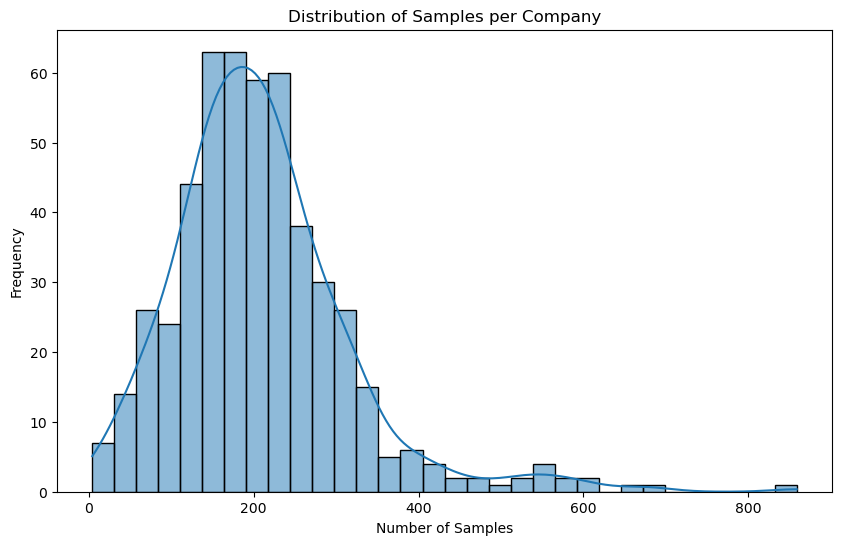

Minimum Samples: 4.0 (Ticker: KVUE)
25th Percentile: 143.0
Median (50%): 196.0
Mean: 208.257
75th Percentile: 252.0
Maximum Samples: 859.0 (Ticker: JPM)

Oldest Report: 1995-03-15 07:54:00 Accession Number: 0000950109-95-000683 (Ticker: LMT)
Newest Report: 2023-11-03 18:20:46 Accession Number: 0001097149-23-000087 (Ticker: ALGN)


In [3]:
# SAMPLE / REPORT STATISTICS:

# Data Shape
print(f'Data Shape: {data.shape}')

# Number of unique companies
unique_companies = data['Ticker'].nunique()
print(f'Number of Unique Companies: {unique_companies}')

# Distribution of samples per company
samples_per_company = data['Ticker'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(samples_per_company, kde=True)
plt.title('Distribution of Samples per Company')
plt.xlabel('Number of Samples')
plt.ylabel('Frequency')
plt.show()
desc_stats = samples_per_company.describe()
min_ticker = samples_per_company.idxmin()
max_ticker = samples_per_company.idxmax()
print(f"Minimum Samples: {desc_stats['min']} (Ticker: {min_ticker})")
print(f"25th Percentile: {desc_stats['25%']}")
print(f"Median (50%): {desc_stats['50%']}")
print(f"Mean: {round(desc_stats['mean'],3)}")
print(f"75th Percentile: {desc_stats['75%']}")
print(f"Maximum Samples: {desc_stats['max']} (Ticker: {max_ticker})")

# Oldest and Newest report
oldest_report_row = data.loc[data['DateTime'] == data['DateTime'].min()]
newest_report_row = data.loc[data['DateTime'] == data['DateTime'].max()]
oldest_report = oldest_report_row['DateTime'].iloc[0]
oldest_ticker = oldest_report_row['Ticker'].iloc[0]
oldest_number = oldest_report_row['Number'].iloc[0]
newest_report = newest_report_row['DateTime'].iloc[0]
newest_ticker = newest_report_row['Ticker'].iloc[0]
newest_number = newest_report_row['Number'].iloc[0]
print()
print(f'Oldest Report: {oldest_report} Accession Number: {oldest_number} (Ticker: {oldest_ticker})')
print(f'Newest Report: {newest_report} Accession Number: {newest_number} (Ticker: {newest_ticker})')

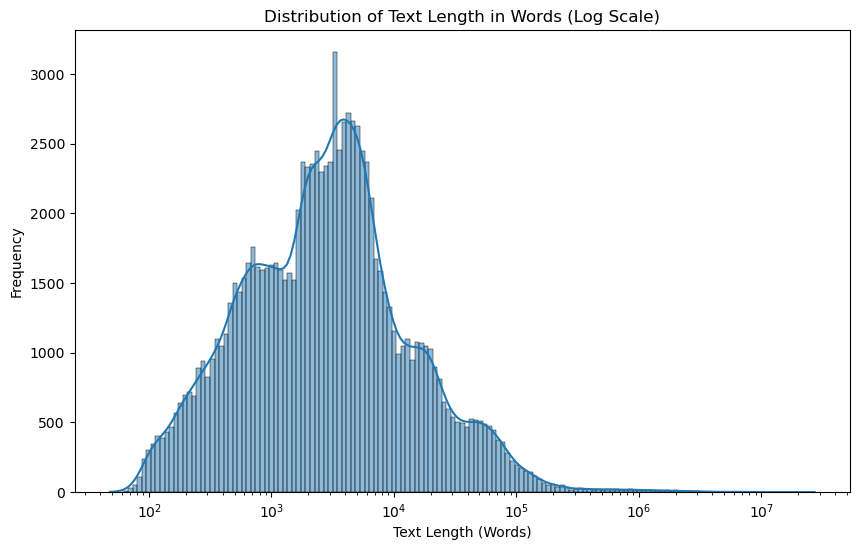

Text Length in Words:
Minimum Words: 48 (Ticker/Num: ILMN 0001110803-17-000019)
25th Percentile: 912.0
Median (50%): 2867.0
Mean: 14314.358
75th Percentile: 6888.0
95th Percentile: 45466.8
Maximum Words: 27318347 (Ticker/Num: ALB 0000915913-22-000025)

Text Length in Characters:
Minimum Characters: 314 (Ticker/Num: ILMN 0001110803-17-000019)
25th Percentile: 5934.0
Median (50%): 18654.0
Mean: 76735.616
75th Percentile: 44473.0
95th Percentile: 276449.4
Maximum Characters: 74955284 (Ticker/Num: ALB 0000915913-22-000025)

Word Lengths:
Minimum Characters: 1
25th Percentile: 2.0
Median (50%): 4.0
Mean: 4.360814389462265
75th Percentile: 6.0
Maximum Characters: 1763 (Index/Pos: 54573/86081)

Number of Unique Words in Corpus: 9439797
Total Number of Words in Corpus: 1496494560
Total Number of Characters in Corpus: 8022325026


In [4]:
# TEXT STATISTICS:

# Average text lengths in words statistics
text_length_words = data['Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(text_length_words, kde=True, log_scale=(True, False))
plt.title('Distribution of Text Length in Words (Log Scale)')
plt.xlabel('Text Length (Words)')
plt.ylabel('Frequency')
plt.show()
min_words = text_length_words.min()
max_words = text_length_words.max()
min_words_ticker = data.loc[text_length_words.idxmin(), 'Ticker']
max_words_ticker = data.loc[text_length_words.idxmax(), 'Ticker']
min_words_number = data.loc[text_length_words.idxmin(), 'Number']
max_words_number = data.loc[text_length_words.idxmax(), 'Number']
print("Text Length in Words:")
print(f"Minimum Words: {min_words} (Ticker/Num: {min_words_ticker} {min_words_number})")
print(f"25th Percentile: {text_length_words.quantile(0.25)}")
print(f"Median (50%): {text_length_words.median()}")
print(f"Mean: {round(text_length_words.mean(),3)}")
print(f"75th Percentile: {text_length_words.quantile(0.75)}")
print(f"95th Percentile: {round(text_length_words.quantile(0.95),3)}")
print(f"Maximum Words: {max_words} (Ticker/Num: {max_words_ticker} {max_words_number})")

# Average text length in chars statistics
text_length_chars = data['Text'].str.len()
min_chars = text_length_chars.min()
max_chars = text_length_chars.max()
min_chars_ticker = data.loc[text_length_chars.idxmin(), 'Ticker']
max_chars_ticker = data.loc[text_length_chars.idxmax(), 'Ticker']
min_chars_number = data.loc[text_length_chars.idxmin(), 'Number']
max_chars_number = data.loc[text_length_chars.idxmax(), 'Number']
print("\nText Length in Characters:")
print(f"Minimum Characters: {min_chars} (Ticker/Num: {min_chars_ticker} {min_chars_number})")
print(f"25th Percentile: {text_length_chars.quantile(0.25)}")
print(f"Median (50%): {text_length_chars.median()}")
print(f"Mean: {round(text_length_chars.mean(),3)}")
print(f"75th Percentile: {text_length_chars.quantile(0.75)}")
print(f"95th Percentile: {round(text_length_chars.quantile(0.95),3)}")
print(f"Maximum Characters: {max_chars} (Ticker/Num: {max_chars_ticker} {max_chars_number})")
print()

# Average word length statistics
word_counter = Counter()
char_counter = 0
word_lengths = []
for text in data['Text']:
    words = text.split()
    word_counter.update(words)
    char_counter += len(text)
    word_lengths.extend([len(word) for word in words])
min_length = np.min(word_lengths)
percentile_25 = np.percentile(word_lengths, 25)
median = np.median(word_lengths)
mean_length = mean(word_lengths)
percentile_75 = np.percentile(word_lengths, 75)
max_length = np.max(word_lengths)
max_length_index = None
max_length_pos = None
for i, text in enumerate(data['Text']):
    for pos, word in enumerate(text.split()):
        if len(word) == max_length:
            max_length_index = i
            max_length_pos = pos
            break
    if max_length_index is not None:
        break
print("Word Lengths:")
print(f"Minimum Characters: {min_length}")
print(f"25th Percentile: {percentile_25}")
print(f"Median (50%): {median}")
print(f"Mean: {mean_length}")
print(f"75th Percentile: {percentile_75}")
print(f"Maximum Characters: {max_length} (Index/Pos: {max_length_index}/{max_length_pos})")
print()

# Whole corpus statistics
unique_words = len(word_counter)
total_words = sum(word_counter.values())
total_chars = char_counter
print(f'Number of Unique Words in Corpus: {unique_words}')
print(f'Total Number of Words in Corpus: {total_words}')
print(f'Total Number of Characters in Corpus: {total_chars}')

Statistical Summary:

Measure    open       close      2d         1w         
Min        -0.4246    -0.5904    -0.5304    -0.6527    
25%        0.0086     -0.0111    -0.0147    -0.0212    
Median     0.0980     0.0006     0.0014     0.0031     
Mean       0.2107     0.0011     0.0017     0.0035     
75%        0.2903     0.0126     0.0176     0.0273     
Max        11.8750    1.0101     1.4343     2.4343     
Std        0.4035     0.0345     0.0418     0.0571     
Var        0.1628     0.0012     0.0017     0.0033     


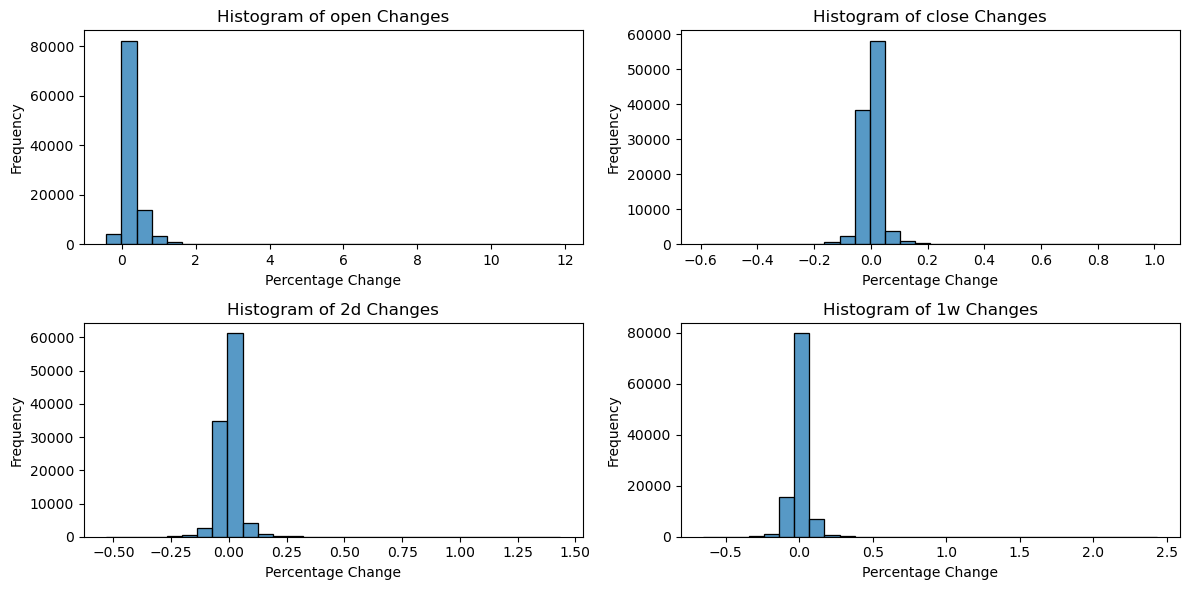

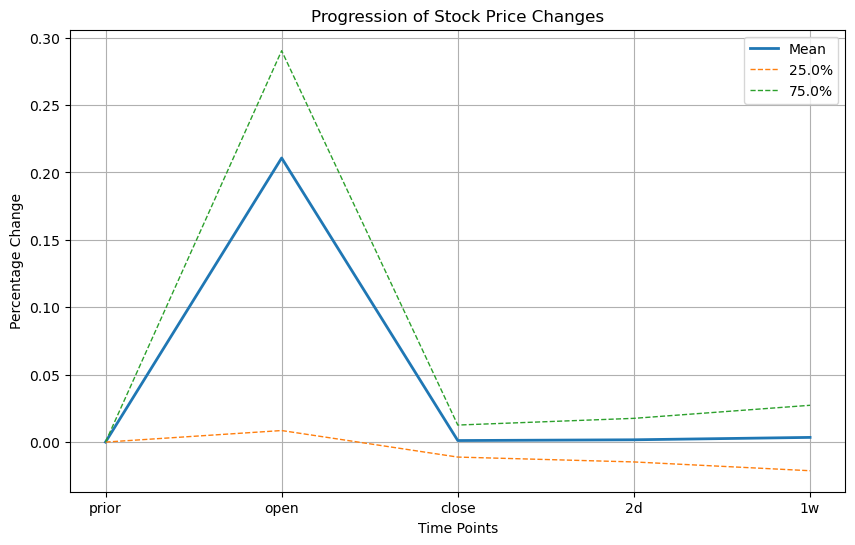

In [5]:
# PRICE STATISTICS:

# General Satistics
columns_of_interest = ['open', 'close', '2d', '1w']
selected_data = data[columns_of_interest]
summary_stats = selected_data.describe().T  # Transpose for better formatting
summary_stats['std'] = selected_data.std()  # Standard Deviation
summary_stats['var'] = selected_data.var()  # Variance
headers = ['Min', '25%', 'Median', 'Mean', '75%', 'Max', 'Std', 'Var']
pandas_headers = ['min', '25%', '50%', 'mean', '75%', 'max', 'std', 'var']  # Corresponding pandas headers
print("Statistical Summary:\n")
print(f"{'Measure':<10}", end=' ')
for column in summary_stats.index:
    print(f"{column:<10}", end=' ')
print()
for i, header in enumerate(headers):
    print(f"{header:<10}", end=' ')
    for column in summary_stats.index:
        print(f"{summary_stats.at[column, pandas_headers[i]]:<10.4f}", end=' ')
    print()
    
# Histograms
plt.figure(figsize=(12, 6))
for i, column in enumerate(selected_data.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(selected_data[column], kde=False, bins=30)
    plt.title(f'Histogram of {column} Changes')
    plt.xlabel('Percentage Change')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show() 
    
# Line Plot for Change Progression
mean_values = selected_data.mean()
quantiles = selected_data.quantile([0.25, 0.75])
plt.figure(figsize=(10, 6))
time_points = ['prior', 'open', 'close', '2d', '1w']
plt.plot(time_points, [0] + mean_values.tolist(), label='Mean', linewidth=2)
for quantile in quantiles.index:
    plt.plot(time_points, [0] + quantiles.loc[quantile].tolist(), label=f'{quantile*100}%', linewidth=1, linestyle='--')
plt.xlabel('Time Points')
plt.ylabel('Percentage Change')
plt.title('Progression of Stock Price Changes')
plt.legend()
plt.grid(True)
plt.show()

Number of Unique Report Types: 23


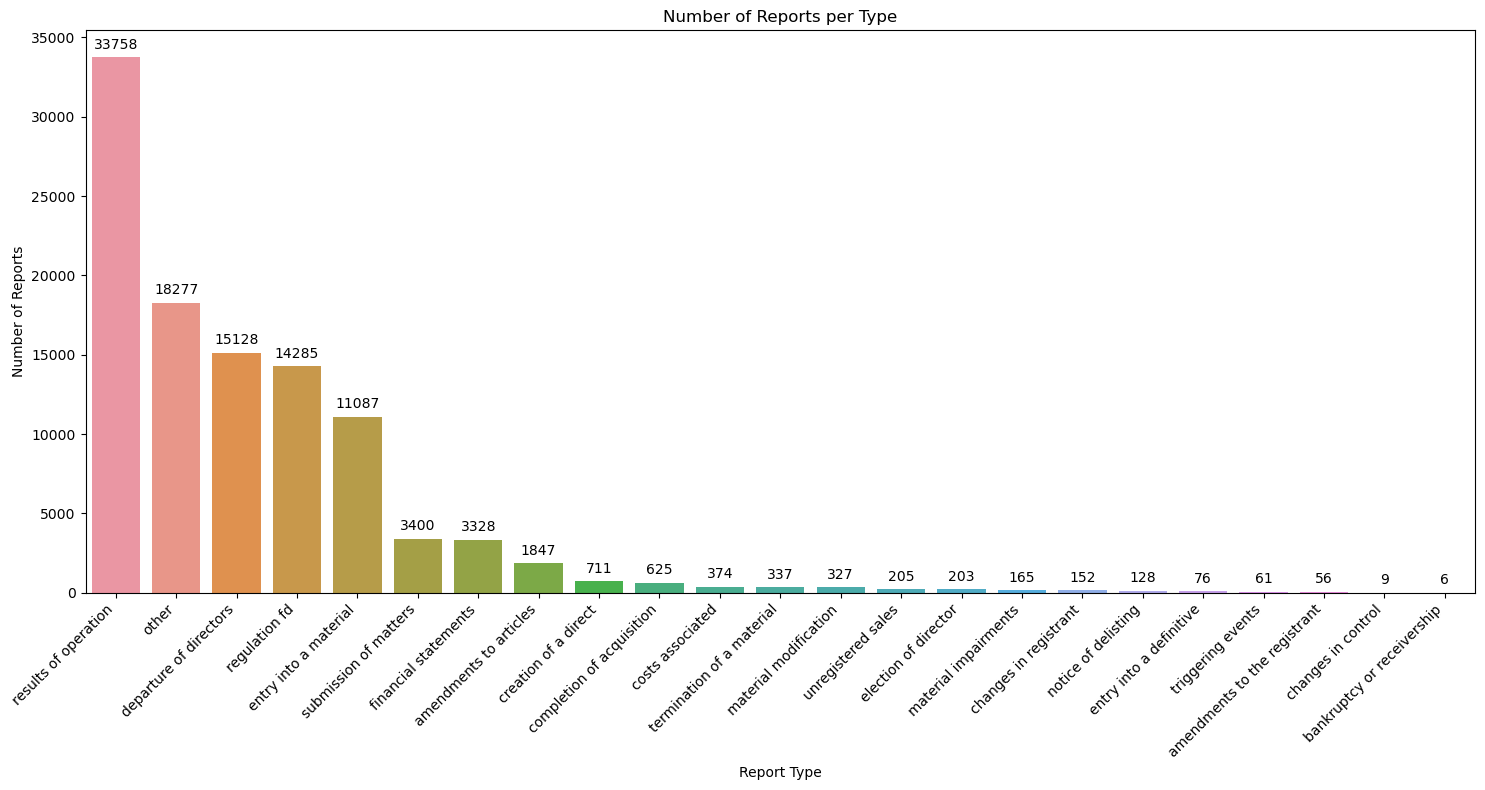

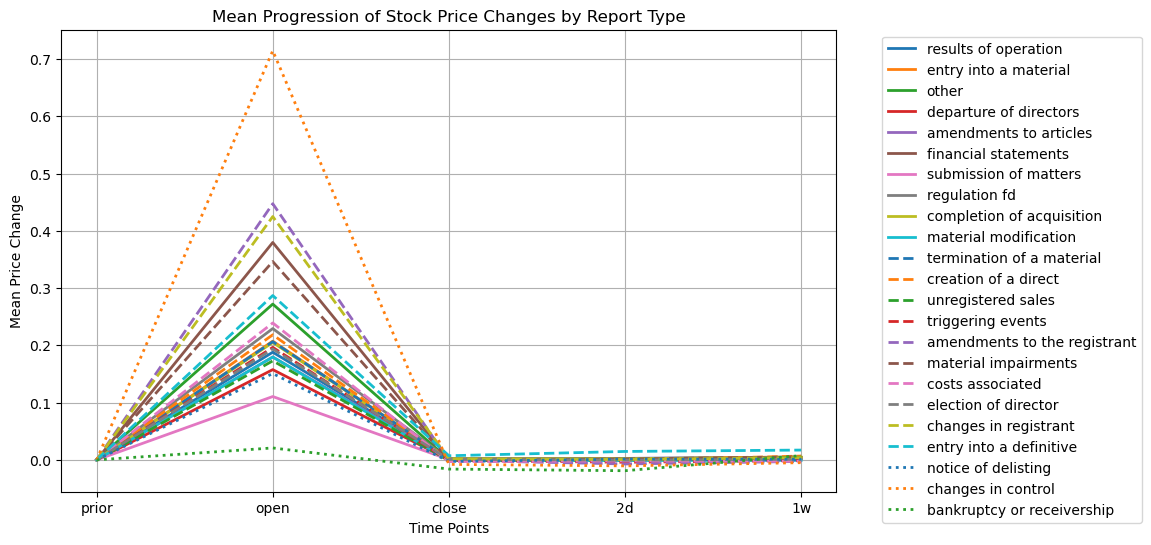

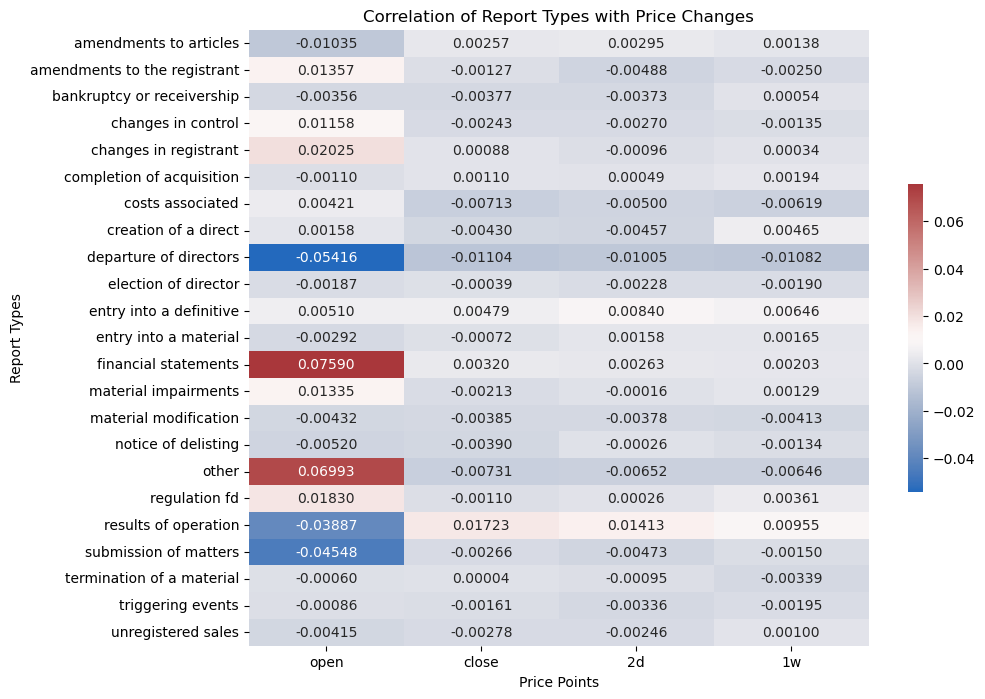

In [6]:
# PER REPORT-TYPE STATISTICS

# Print number of unique types
unique_types_count = data['Type'].nunique()
print(f'Number of Unique Report Types: {unique_types_count}')

# Visual for number of reports per type
plt.figure(figsize=(15, 8))
type_counts = data['Type'].value_counts()
barplot = sns.barplot(x=type_counts.index, y=type_counts.values)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Reports per Type')
plt.xlabel('Report Type')
plt.ylabel('Number of Reports')
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()

# Line Plot for Mean Price Change Progression for Each Type
time_points = ['open', 'close', '2d', '1w']
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors
line_styles = ['-', '--', ':']
color_style_combinations = [(color, style) for style in line_styles for color in colors]
color_style_cycler = cycle(color_style_combinations)
for report_type in data['Type'].unique():
    selected_data = data[data['Type'] == report_type][time_points]
    mean_values = selected_data.mean()
    color, style = next(color_style_cycler)
    plt.plot(['prior'] + time_points, [0] + mean_values.tolist(), label=report_type, color=color, linestyle=style, linewidth=2)
plt.xlabel('Time Points')
plt.ylabel('Mean Price Change')
plt.title('Mean Progression of Stock Price Changes by Report Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Correlation of price changes with report types
# For correlation, we need to encode the 'Type' column as numerical values
price_data = data[['open', 'close', '2d', '1w']]
type_dummies = pd.get_dummies(data['Type'])
correlation_data = pd.concat([price_data, type_dummies], axis=1)
correlation_matrix = correlation_data.corr().iloc[4:, :4]
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".5f", cmap='vlag', cbar_kws={'shrink': .5})
plt.title('Correlation of Report Types with Price Changes')
plt.ylabel('Report Types')
plt.xlabel('Price Points')
plt.show()

# Traditional ML Baselines:

In [17]:
# STANDARD METRICS FUNCTION
def metrics(y, y_pred, verbose=True):
    metric_names = ['MAE', 'MSE', 'RMSE', 'Directional Acc.']
    targets = ['Open', 'Close', '2d', '1w']
    def calculate_metrics(actual, predictions):
        mae = mean_absolute_error(actual, predictions)
        mse = mean_squared_error(actual, predictions)
        rmse = np.sqrt(mse)
        directional_acc = np.mean(np.sign(predictions) == np.sign(actual))
        return mae, mse, rmse, directional_acc
    # Initialize dictionaries to store metric values for each target
    metric_values = {metric: [] for metric in metric_names}
    for target in targets:
        actual_col = y[target.lower()] if target.lower() in y else y[target]
        pred_col = y_pred[target] if target in y_pred else y_pred[target.lower()]
        mae, mse, rmse, dir_acc = calculate_metrics(actual_col, pred_col)
        # Append metric values for each target
        metric_values['MAE'].append(mae)
        metric_values['MSE'].append(mse)
        metric_values['RMSE'].append(rmse)
        metric_values['Directional Acc.'].append(dir_acc)
    # Print the metrics if verbose
    if verbose:
        print(f"{'Metric':<11} {'Open':>10} {'Close':>10} {'2d':>6} {'1w':>9}")
        for metric in metric_names:
            print(f"{metric:<16}", end='')
            for value in metric_values[metric]:
                print(f"{value:>10.6f}", end='')
            print()
    # Calculate averages
    avg_metrics = {metric: sum(metric_values[metric]) / len(targets) for metric in metric_names}
    return avg_metrics['MAE'], avg_metrics['MSE'], avg_metrics['RMSE'], avg_metrics['Directional Acc.']

In [18]:
# NAIVE PREDICTIONS
mean_predictions = [0.210727471513486225296318821165, 0.001143896384763931151420934818,
                    0.001702783353842217710025219723, 0.003472720157164387727588561461]
median_predictions = [0.097988514303040799569011198855, 0.000607450323172899946458369591,
                      0.001363761885313299893063287982, 0.003126713273881800200099112530]
y = data[['open', 'close', '2d', '1w']]
mean_y_pred = {target: [mean_predictions[i]] * len(data) for i, target in enumerate(y.columns)}
median_y_pred = {target: [median_predictions[i]] * len(data) for i, target in enumerate(y.columns)}
print("Mean Naive Performance:")
_=metrics(y, mean_y_pred)
print()
print("Median Naive Performance:")
_=metrics(y, median_y_pred)

Mean Naive Performance:
Metric            Open      Close     2d        1w
MAE               0.212537  0.020322  0.025803  0.036486
MSE               0.162821  0.001188  0.001749  0.003260
RMSE              0.403511  0.034466  0.041826  0.057094
Directional Acc.  0.851078  0.513090  0.523554  0.535435

Median Naive Performance:
Metric            Open      Close     2d        1w
MAE               0.192065  0.020314  0.025800  0.036485
MSE               0.175531  0.001188  0.001750  0.003260
RMSE              0.418964  0.034470  0.041828  0.057096
Directional Acc.  0.851078  0.513090  0.523554  0.535435


In [ ]:
# LINEAR REGRESSION with TF-IDF
X = data['Text']
y = data[['open', 'close', '2d', '1w']]
# Feature extraction
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(X)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=1)
# Train a model for each target and store predictions
y_pred_dict = {}
for column in y.columns:
    model = LinearRegression()
    model.fit(X_train, y_train[column])
    y_pred_dict[column] = model.predict(X_test)
print("Linear Regression Performance")
metrics(y_test, y_pred_dict)

Linear Regression Performance  
Metric            Open      Close     2d        1w  
MAE               0.173750  0.020573  0.026099  0.037068  
MSE               0.129760  0.001129  0.001694  0.003243  
RMSE              0.360222  0.033608  0.041163  0.056949  
Directional Acc.  0.799703  0.503133  0.506720  0.525754  
LR mainly outperfroms naive on open metrics.  
However, directional accuracy falters.  

In [ ]:
# SVM with TF-IDF & Truncated SVD
# Feature extraction
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(data['Text'])
# Dimensionality Reduction with Truncated SVD
svd = TruncatedSVD(n_components=80, random_state=1)
X_reduced = svd.fit_transform(X_tfidf)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, data[['open', 'close', '2d', '1w']], test_size=0.2, random_state=1)
# Train a model for each target and store predictions
y_pred_dict = {}
for column in y_train.columns:
    svm_model = make_pipeline(StandardScaler(with_mean=False), SVR(kernel='linear'))
    svm_model.fit(X_train, y_train[column])
    y_pred_dict[column] = svm_model.predict(X_test)
# Evaluate the performance
print("SVM Performance")
metrics(y_test, y_pred_dict)

SVM Performance  
Metric            Open      Close     2d        1w  
MAE               0.166866  0.023959  0.027303  0.037027  
MSE               0.153924  0.001288  0.001755  0.003230  
RMSE              0.392332  0.035885  0.041890  0.056830  
Directional Acc.  0.828495  0.493759  0.500933  0.516381  

# Fine-Tuning BERT

In [7]:
# Tokenize Data:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_shortened_texts(texts, char_limit=3000, max_length=512):
    truncated_texts = texts.str.slice(0, char_limit)
    tokenized_texts = [tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt') for text in truncated_texts]
    # Extract input_ids and attention_mask
    input_ids = [t['input_ids'][0] for t in tokenized_texts]
    attention_masks = [t['attention_mask'][0] for t in tokenized_texts]
    return list(zip(input_ids, attention_masks))  # Return a list of tuples
data['input_ids'], data['attention_mask'] = zip(*tokenize_shortened_texts(data['Text']))

In [63]:
# Dataset setup:
class SP500Dataset(Dataset):
    def __init__(self, texts, attention_masks, targets):
        self.texts = texts
        self.attention_masks = attention_masks
        self.targets = torch.tensor(targets.values, dtype=torch.float)
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.texts[idx], self.attention_masks[idx], self.targets[idx]
targets = data[['open', 'close', '2d', '1w']]
dataset = SP500Dataset(data['input_ids'], data['attention_mask'], targets)
# Model setup:
class BertForRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.2)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 4)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        # Use the pooled output of the [CLS] token
        cls_output = outputs.pooler_output
        dropout_output = self.dropout(cls_output)
        return self.regressor(dropout_output)
model = BertForRegression()

In [64]:
# Training Setup

# Logging setup
logging.basicConfig(filename='BERT_8K.log', level=logging.INFO, format='%(asctime)s - %(message)s')
# Hyperparameters
batch_size = 16
num_epochs = 100
learning_rate = 2e-5
# Splitting data into train, validation, and test sets
train_val_data, test_data = train_test_split(dataset, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.15 / 0.85, random_state=42)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
# Prepare model
device = torch.device("cuda")
model = BertForRegression().to(device)
# Optimizer and criterion
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.MSELoss()

In [65]:
# Training
best_val_loss = best_mae = best_mse = best_rmse = np.inf
best_dir_acc = 0
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_loss = 0
    for input_ids, attention_mask, targets in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    # Validation loop
    model.eval()
    total_val_loss = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for input_ids, attention_mask, targets in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            targets = targets.to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()
            # Collect all predictions and actual values
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    avg_val_loss = total_val_loss / len(val_loader)
    # Convert collected data to dataframes for metric calculation
    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)
    target_columns = ['open', 'close', '2d', '1w']  # Column names
    all_predictions_df = pd.DataFrame(all_predictions, columns=target_columns)
    all_targets_df = pd.DataFrame(all_targets, columns=target_columns)
    # Calculate additional metrics
    avg_mae, avg_mse, avg_rmse, avg_dir_acc = metrics(all_targets_df, all_predictions_df)
    # Log and print message
    epoch_time = time.time() - start_time
    log_message = f"Epoch [{epoch+1:03d}/{num_epochs}]: Train Loss: {avg_train_loss:.4f} | " \
                  f"Val [ Loss: {avg_val_loss:.4f} | MAE: {avg_mae:.4f} | MSE: {avg_mse:.4f} | " \
                  f"RMSE: {avg_rmse:.4f} | Dir. Acc: {avg_dir_acc:.4f} ] Time: {epoch_time}"
    logging.info(log_message)
    print(log_message)
    # Save best models
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'bestLoss.pt')
        logging.info("Saved new best model based on loss")
        print("Saved new best model based on loss")
    if avg_mae < best_mae:
        best_mae = avg_mae
        torch.save(model.state_dict(), 'bestMAE.pt')
        logging.info("Saved new best model based on MAE")
        print("Saved new best model based on MAE")
    if avg_mse < best_mse:
        best_mse = avg_mse
        torch.save(model.state_dict(), 'bestMSE.pt')
        logging.info("Saved new best model based on MSE")
        print("Saved new best model based on MSE")
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        torch.save(model.state_dict(), 'bestRMSE.pt')
        logging.info("Saved new best model based on RMSE")
        print("Saved new best model based on RMSE")
    if avg_dir_acc > best_dir_acc:
        best_dir_acc = avg_dir_acc
        torch.save(model.state_dict(), 'bestDirAcc.pt')
        logging.info("Saved new best model based on Directional Accuracy")
        print("Saved new best model based on Directional Accuracy")
    # Save the last model
    torch.save(model.state_dict(), 'latestModel.pt')
    scheduler.step(avg_val_loss)

Metric                 Open      Close         2d         1w
MAE               0.093692  0.021148  0.026500  0.036737
MSE               0.049247  0.001254  0.001762  0.003091
RMSE              0.221916  0.035414  0.041980  0.055594
Directional Acc.  0.815967  0.507461  0.527101  0.532585
Epoch [001/100]: Train Loss: 0.0224 | Val [ Loss: 0.0138 | MAE: 0.0445 | MSE: 0.0138 | RMSE: 0.0887 | Dir. Acc: 0.5958 ] Time: 1880.6208550930023
Saved new best model based on loss
Saved new best model based on MAE
Saved new best model based on MSE
Saved new best model based on RMSE
Saved new best model based on Directional Accuracy
Metric                 Open      Close         2d         1w
MAE               0.085966  0.020578  0.026103  0.036875
MSE               0.030281  0.001225  0.001737  0.003129
RMSE              0.174014  0.034994  0.041680  0.055937
Directional Acc.  0.814501  0.514858  0.527611  0.520597
Epoch [002/100]: Train Loss: 0.0120 | Val [ Loss: 0.0091 | MAE: 0.0424 | MSE: 0.0091 | 

KeyboardInterrupt: 

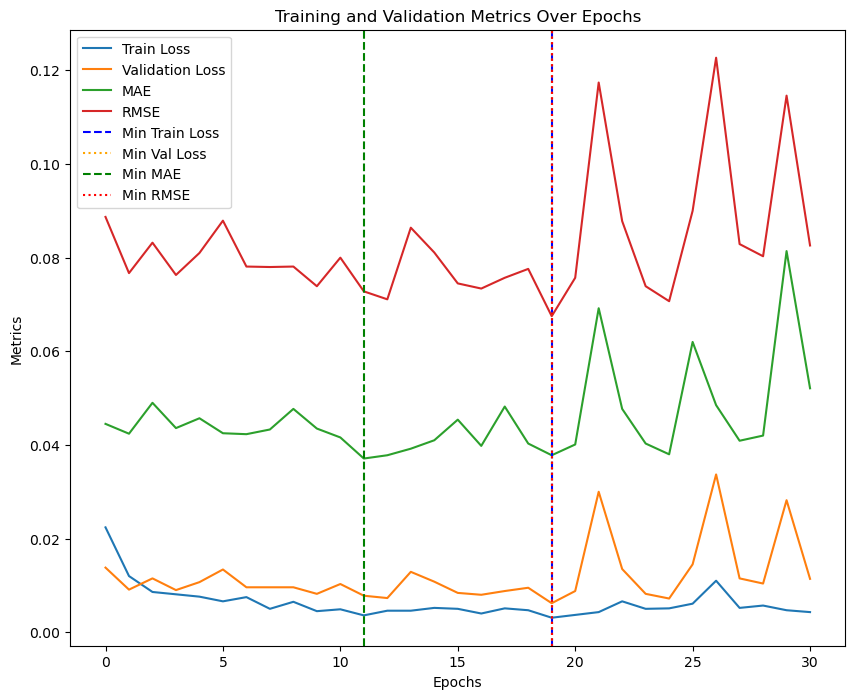

In [37]:
# Training Visualization
# MSE NOT INCLUDED AS IT IS VALIDATION LOSS
df = pd.read_csv('BERT Tuning/Training.csv')
plt.figure(figsize=(10, 8))
plt.plot(df['tLoss'], label='Train Loss')
plt.plot(df['vLoss'], label='Validation Loss')
plt.plot(df['MAE'], label='MAE')
plt.plot(df['RMSE'], label='RMSE')
min_tLoss_index = df['tLoss'].idxmin()
plt.axvline(min_tLoss_index, color='blue', linestyle='dashed', label='Min Train Loss')
min_vLoss_index = df['vLoss'].idxmin()
plt.axvline(min_vLoss_index, color='orange', linestyle='dotted', label='Min Val Loss')
min_MAE_index = df['MAE'].idxmin()
plt.axvline(min_MAE_index, color='green', linestyle='dashed', label='Min MAE')
min_RMSE_index = df['RMSE'].idxmin()
plt.axvline(min_RMSE_index, color='red', linestyle='dotted', label='Min RMSE')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics Over Epochs')
plt.legend()
plt.show()

In [66]:
# BERT Evaluation:
model_filenames = ['bestLoss.pt', 'bestMAE.pt', 'bestMSE.pt', 'bestRMSE.pt', 'bestDirAcc.pt', 'latestModel.pt']
model_descriptions = ['Best Loss Model', 'Best MAE Model', 'Best MSE Model', 'Best RMSE Model', 'Best Directional Accuracy Model', 'Latest Model']
for model_file, description in zip(model_filenames, model_descriptions):
    # Load the model
    model.load_state_dict(torch.load(model_file))
    model.to(device)
    model.eval()
    # Evaluate on test set
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for input_ids, attention_mask, targets in test_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            targets = targets.to(device)

            outputs = model(input_ids, attention_mask)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)
    all_predictions_df = pd.DataFrame(all_predictions, columns=target_columns)
    all_targets_df = pd.DataFrame(all_targets, columns=target_columns)
    # Call metrics function
    print(f"{description}:")
    avg_mae, avg_mse, avg_rmse, avg_dir_acc = metrics(all_targets_df, all_predictions_df)
    print()

Best Loss Model:
Metric                 Open      Close         2d         1w
MAE               0.067501  0.020770  0.026341  0.036658
MSE               0.017376  0.001200  0.001782  0.003279
RMSE              0.131820  0.034634  0.042219  0.057265
Directional Acc.  0.761638  0.485206  0.475067  0.518748

Best MAE Model:
Metric                 Open      Close         2d         1w
MAE               0.063282  0.020881  0.026389  0.037318
MSE               0.018450  0.001217  0.001794  0.003357
RMSE              0.135829  0.034883  0.042357  0.057939
Directional Acc.  0.853207  0.507014  0.520150  0.533159

Best MSE Model:
Metric                 Open      Close         2d         1w
MAE               0.067501  0.020770  0.026341  0.036658
MSE               0.017376  0.001200  0.001782  0.003279
RMSE              0.131820  0.034634  0.042219  0.057265
Directional Acc.  0.761638  0.485206  0.475067  0.518748

Best RMSE Model:
Metric                 Open      Close         2d         1w
MAE

# Further Models:
I am actively experimenting with additional models such as FinBERT, XLNet, and GPT models,  
progress will be updated.  

# Model Comparison
Model performance visualization will be updated once further models are completed.

In [42]:
df = pd.read_csv('Metrics.csv')
df.head(100)

,Model,Open,Close,2d,1w
0,NaN,NaN,NaN,NaN,NaN
1,Naive_Mean,NaN,NaN,NaN,NaN
2,Metric,Open,Close,2d,1w
3,MAE,0.212537,0.020322,0.025803,0.036486
4,MSE,0.162821,0.001188,0.001749,0.00326
5,RMSE,0.403511,0.034466,0.041826,0.057094
6,Directional_Acc.,0.851078,0.51309,0.523554,0.535435
7,NaN,NaN,NaN,NaN,NaN
8,Naive_Median,NaN,NaN,NaN,NaN
9,Metric,Open,Close,2d,1w
